In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.font_manager import fontManager, FontProperties
import ptitprince as pt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import pingouin as pg
import statsmodels.api as sm
import language_tool_python as ltp
from PIL import Image
%matplotlib notebook
%matplotlib inline

def get_img(name):
    path = "font/emojis/{}.png".format(name)

    if name == 'Human':
        img = plt.imread(path)
    else:
        img = np.asarray(Image.open(path).resize((136, 128)))

    #  im = plt.imread(img)

    return img

def offset_image(coord, name, ax, size=0.5):
    img = get_img(name)
    im = OffsetImage(img, zoom=size)
    im.image.axes = ax
    ab = AnnotationBbox(im, (coord, 0),  xybox=(0., -21.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)
    ax.add_artist(ab)

def raincloud(x, y, markersize, df, order=None, hue=None):
    # adding color
    pal = sns.color_palette()
    if df is not None:
        means = df.groupby([x])[y].mean().reindex(order)
    else:
        if len(order) > 2:
            raise Exception('Too many unique x values for this custom plot')

        mean_1 = np.mean([i[0] for i in zip(y, x) if i[1] == order[0]])
        mean_2 = np.mean([i[0] for i in zip(y, x) if i[1] == order[1]])
        means = [mean_1, mean_2]

    dodge = None
    if hue:
        means = df.groupby([x, hue])[y].mean().reindex(order)
        dodge = True
        
    sns.scatterplot(
        x=means.index,
        y=means,
        color='white',
        edgecolor='black',
        s=150/2, linewidth=1.5, zorder=4)

    ax = pt.half_violinplot(x=x, y=y, data=df, palette=pal, bw=.25, cut=0., linewidth=0,
                            scale="area", width=.7, inner=None, orient='v', zorder=1, order=order, hue=hue, dodge=dodge)
    # pt.RainCloud(x=x, y=y, data=df, palette=pal, bw=.25, width_viol=.6, orient='v', zorder=2, order=order, hue=hue, dodge=dodge)

    ax = sns.stripplot(x=x, y=y, data=df, palette=pal, edgecolor="white",  linewidth=1, order=order,
                       size=markersize, orient='v', zorder=2, jitter=1, alpha=0.6, hue=hue, dodge=dodge)

    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=.8,
     edgecolor='black', capsize=.08, zorder=3, order=order, hue=hue, dodge=dodge)

In [2]:

f1 = 'HUMANS/turing_dv3_82.csv'
f2 = 'HUMANS/turing_109.csv'
f3 = 'HUMANS/turing_prolific_79.csv'
f4 = 'HUMANS/turing_dv2_humanized_79.csv'
f5 = 'HUMANS/turing_dv2_ai_74.csv'

df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)
df4 = pd.read_csv(f4)
df5 = pd.read_csv(f5)

for df, n_rows, engine in zip([df1, df2, df3, df4, df5], [135, 138, 138, 138, 147], ['dv3', 'dv2', 'dv2_prolific', 'dv2_humanized', 'dv2_ai']):
    df = df[df.prolific_id.isin(df.prolific_id.value_counts()[
                                df.prolific_id.value_counts() == n_rows].index)]
    # df = df[~df.prolific_id.str.contains('anon')] 
    # df = df[~df.prolific_id.str.contains('notfound')]

    print("complete =", (df.groupby('prolific_id').prolific_id.count() == n_rows).sum())
    print("incomplete =", (df.groupby(
        'prolific_id').prolific_id.count() != n_rows).sum())
    # print("dataset_id that are complete =", df.dataset_id.value_counts()==138)
    print("dataset_id that are incomplete =",
          [
              i for i in range(77)
              if i not in df.dataset_id.value_counts().index
          ])
    print("dataset_id that are complete =",
          [
              i for i in range(77)
              if i in df.dataset_id.value_counts().index
          ])

    print("dataset_id that are incomplete =",
          len(
              [i for i in range(77) if i not in df.dataset_id.value_counts().index]))

    df.loc[:, 'correct'] = None
    df.loc[:, 'correct'] = df.correct.astype(bool)
    df.loc[:, 'agree1'] = None
    df.loc[:, 'agree1'] = df.agree1.astype(bool)
    
    df.loc[:, 'agree2'] = None
    df.loc[:, 'agree2'] = df.agree2.astype(bool)

    print(set(df.answer.unique()))
    
    df.loc[df.q_id == 1, 'agree2'] = df.answer.str.contains('Yes')
    df.loc[df.q_id == 0, 'agree1'] = df.answer.str.contains('Yes')

    # clear weird characters in answers
    df.loc[df.answer.str.contains('Yes'), 'answer'] = 'Yes'
    df.loc[(df.answer.str.contains('No')) & (df.q_id!=2), 'answer'] = 'No'
    df.loc[(df.answer.str.contains('AI')) & (~df.answer.str.contains('Not')), 'answer'] = 'AI'
    df.loc[df.answer.str.contains('Human'), 'answer'] = 'Human'

    print(set(df.answer.unique()))

    df.loc[df.q_id == 2, 'correct'] = df.source == df.answer
    if engine == 'dv2_prolific':
        df.loc[df.q_id == 2, 'correct'] = \
            ((df.source == 'Human') & (df.answer == 'Prolific')) | ((df.source == 'AI') & (df.answer == 'Not Prolific'))
    if engine == 'dv2_ai':
        df.loc[df.q_id == 2, 'correct'] = \
            ((df.source == 'AI_humanized') & (df.answer == 'Not an AI')) | ((df.source == 'AI') & (df.answer == 'AI'))
        df.loc[df.source=='AI_humanized', 'item_id'] = (df[df.source=='AI_humanized'].item_id.astype(str)+"2").astype(int)
        df.loc[df.source=='AI', 'item_id'] = (df[df.source=='AI'].item_id.astype(str)+"1").astype(int)
        # df.loc[df.source=='AI_humanized', 'source'] = 'Human'
        # df.loc[df.answer=='Not an AI', 'answer'] = 'Human'


    # add correct and agree1 to all rows where item id is the same (easier to plot)
    for i in df.item_id.unique():
    #    df.loc[df.item_id == i, 'correct'] = \
        #    df[(df.item_id == i) & (df.q_id == 2)].correct.values[0]
       df.loc[(df.item_id == i) & (df.q_id==2), 'agree1'] = \
            df[(df.item_id == i) & (df.q_id == 0)].agree1.values[0]

       df.loc[(df.item_id == i) & (df.q_id==2), 'agree2'] = \
           df[(df.item_id == i) & (df.q_id == 1)].agree2.values[0]


    ## df['agree1']
    #df['agree_both'] = df.agree1 & df.agree2
    #df['disagree_both'] = ~df.agree1 & ~df.agree2
    
    # drop where q_id == 0 or 1
    df = df[df.q_id == 2]
    
    df.loc[:, 'engine'] = engine
    
    exec(f'{engine} = df.copy()')

np.random.seed(123)
# TODO: keep only one subject per dataset id
ids_to_keep_dv2 = []
ids_to_keep_dv3 = []
for i in range(77):
    ids_to_keep_dv2.append(
        np.random.choice(dv2[dv2.dataset_id == i].prolific_id.unique()))
    try:
        ids_to_keep_dv3.append(
            np.random.choice(dv3[dv3.dataset_id == i].prolific_id.unique()))
    except:
        print('Index error', i)
dv2 = dv2[dv2.prolific_id.isin(ids_to_keep_dv2)]
dv3 = dv3[dv3.prolific_id.isin(ids_to_keep_dv3)]
# dv2_prolific = dv2_prolific[dv2_prolific.prolific_id.isin(ids_to_keep)]
# ids = dv2.groupby('dataset_id').prolific_id.transform('nunique') > 1
# print(ids)
df = pd.concat([dv2, dv3, dv2_prolific, dv2_humanized, dv2_ai])


complete = 82
incomplete = 0
dataset_id that are incomplete = [76]
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
dataset_id that are incomplete = 1
{'AI', 'Human', 'No', 'Yes'}
{'AI', 'Human', 'No', 'Yes'}


/tmp/ipykernel_70992/1767320652.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = None
/tmp/ipykernel_70992/1767320652.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = df.correct.astype(bool)
/tmp/ipykernel_70992/1767320652.py:39: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

complete = 112
incomplete = 0
dataset_id that are incomplete = []
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
dataset_id that are incomplete = 0
{'âœ˜No', 'No', 'ðŸ¤AI', 'Human', 'âœYes', 'AI', 'ðŸ¨â\x8dðŸ¦°Human', 'Yes'}


/tmp/ipykernel_70992/1767320652.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = None
/tmp/ipykernel_70992/1767320652.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = df.correct.astype(bool)
/tmp/ipykernel_70992/1767320652.py:39: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

{'Yes', 'No', 'AI', 'Human'}
complete = 79
incomplete = 0
dataset_id that are incomplete = []
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
dataset_id that are incomplete = 0
{'Prolific', 'No', 'Not Prolific', 'Yes'}
{'Prolific', 'No', 'Not Prolific', 'Yes'}


/tmp/ipykernel_70992/1767320652.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = None
/tmp/ipykernel_70992/1767320652.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = df.correct.astype(bool)
/tmp/ipykernel_70992/1767320652.py:39: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

complete = 79
incomplete = 0
dataset_id that are incomplete = []
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
dataset_id that are incomplete = 0
{'âœ˜No', 'No', 'ðŸ¤AI', 'Human', 'âœYes', 'AI', 'ðŸ¨â\x8dðŸ¦°Human', 'Yes'}
{'Yes', 'No', 'AI', 'Human'}


/tmp/ipykernel_70992/1767320652.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = None
/tmp/ipykernel_70992/1767320652.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = df.correct.astype(bool)
/tmp/ipykernel_70992/1767320652.py:39: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

complete = 72
incomplete = 0
dataset_id that are incomplete = [72, 73, 74, 75, 76]
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
dataset_id that are incomplete = 5
{'Yes', 'Not an AI', 'No', 'AI'}
{'Yes', 'Not an AI', 'No', 'AI'}


/tmp/ipykernel_70992/1767320652.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = None
/tmp/ipykernel_70992/1767320652.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = df.correct.astype(bool)
/tmp/ipykernel_70992/1767320652.py:39: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

Index error 76



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       0.64      0.95      0.76       436
           1       0.63      0.15      0.24       273

    accuracy                           0.64       709
   macro avg       0.64      0.55      0.50       709
weighted avg       0.64      0.64      0.56       709



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


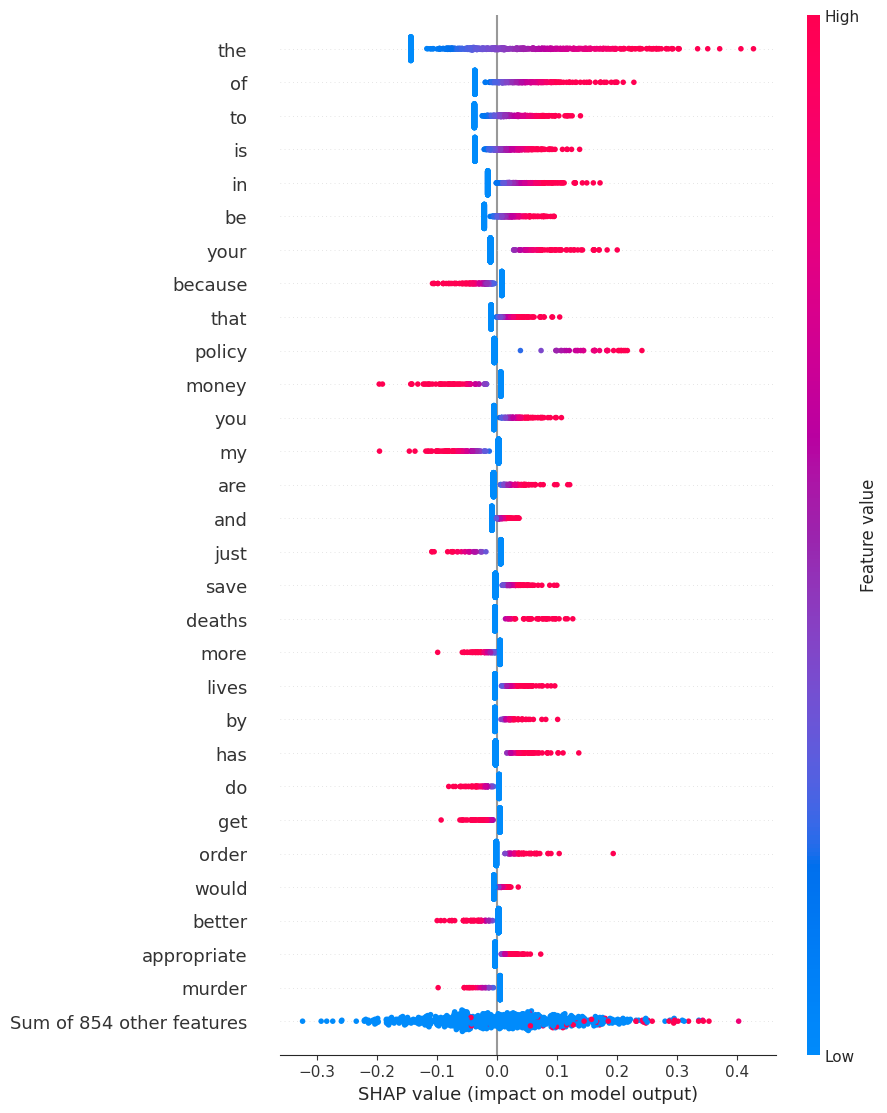

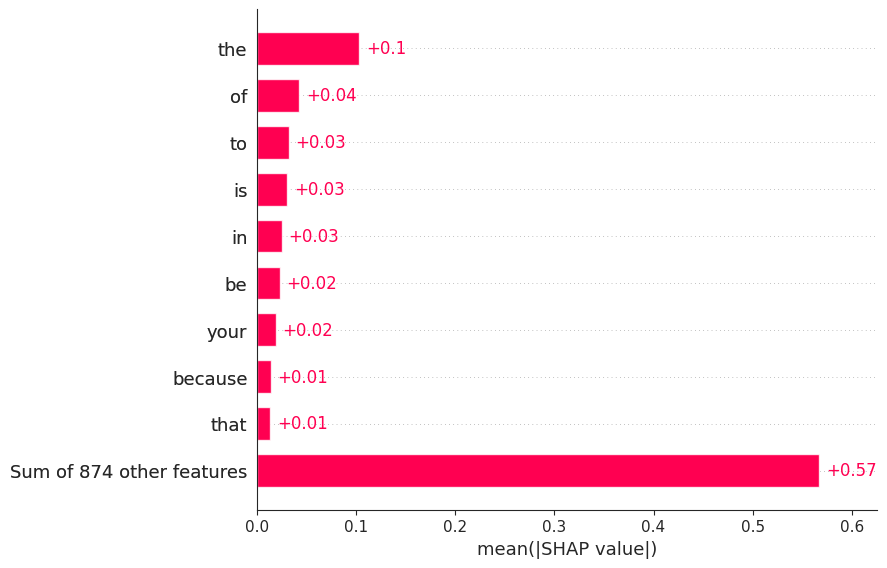

In [162]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import shap

np.random.seed(101)
shap.initjs()


engine = 'dv2'
df2 = df[df.engine == engine]

#remove html symbols (e.g. &amp;)
import html
df2['a1'] = df2.a1.map(lambda x: html.unescape(x))

corpus = df2['a1']
y = (df2['answer'] == 'AI').astype(int)

# Split dataset
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)


vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train).toarray() # sparse also works but Explanation slicing is not yet supported
X_test = vectorizer.transform(corpus_test).toarray()

model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)

model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

explainer = shap.Explainer(model, X_train, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values, max_display=30)
# shap.plots.text(shap_values[:,:,"AI"])
shap.plots.bar(shap_values)

<Axes: >

iteritems is deprecated and will be removed in a future version. Use .items instead.


<Axes: >

iteritems is deprecated and will be removed in a future version. Use .items instead.


<Axes: >

Text(0, 0.5, 'Frequency')

Text(0.5, 0, 'Answer')

Text(0.5, 1.0, 'word =  my ')

<Axes: >

iteritems is deprecated and will be removed in a future version. Use .items instead.


<Axes: >

iteritems is deprecated and will be removed in a future version. Use .items instead.


<Axes: >

Text(0, 0.5, 'Frequency')

Text(0.5, 0, 'Answer')

Text(0.5, 1.0, 'word =  i ')

<Axes: >

iteritems is deprecated and will be removed in a future version. Use .items instead.


<Axes: >

iteritems is deprecated and will be removed in a future version. Use .items instead.


<Axes: >

Text(0, 0.5, 'Frequency')

Text(0.5, 0, 'Answer')

Text(0.5, 1.0, 'word =  the ')

<Axes: >

iteritems is deprecated and will be removed in a future version. Use .items instead.


<Axes: >

iteritems is deprecated and will be removed in a future version. Use .items instead.


<Axes: >

Text(0, 0.5, 'Frequency')

Text(0.5, 0, 'Answer')

Text(0.5, 1.0, 'word =  because ')

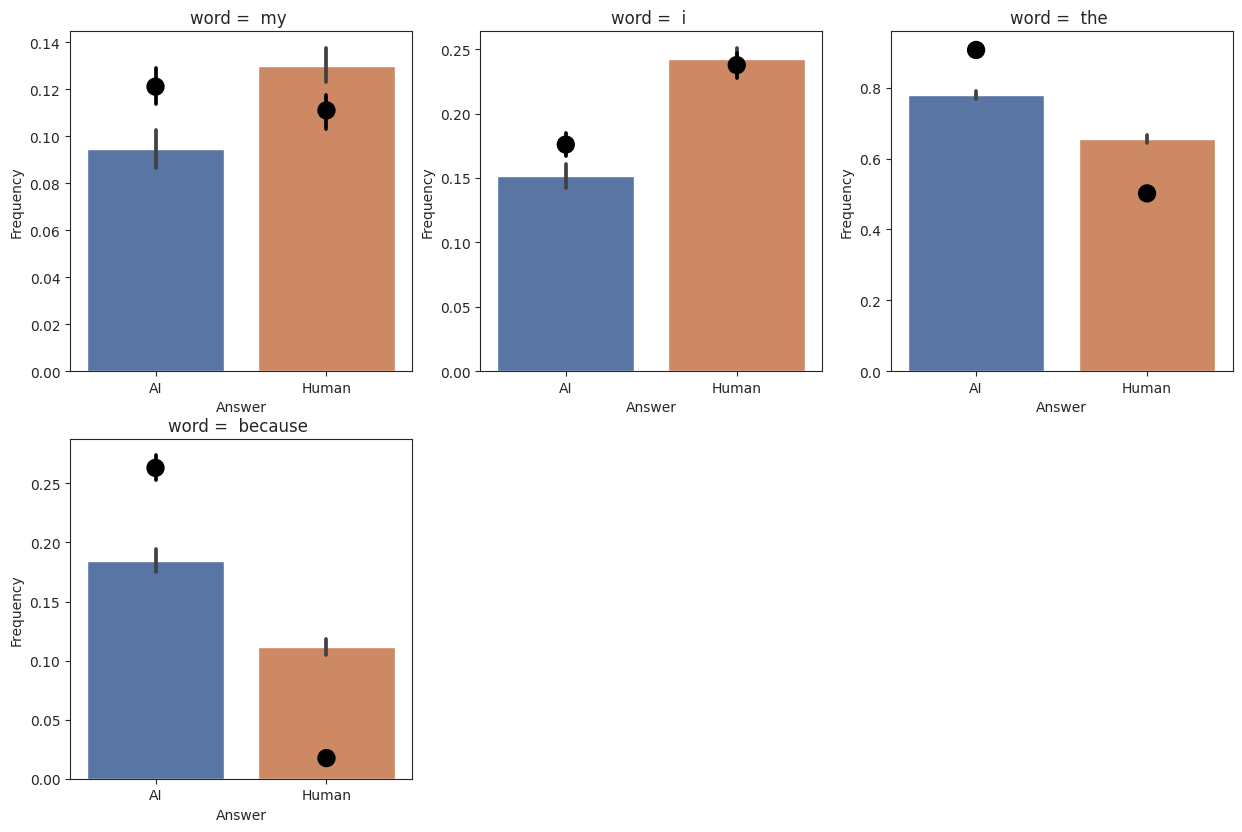

In [170]:
sns.set({'figure.figsize':(15,15)})
sns.set_style('ticks')
word = ['my', 'i', 'the', 'because']
word = [' ' + w + ' ' for w in word]


count = 0
for w in word:
    count += 1
    plt.subplot(3,3,count)

    x1 = df2[df2.answer=='AI'].a1.str.contains(w)
    x2 = df2[df2.answer=='Human'].a1.str.contains(w)
    
    x3 = df2[df2.source=='AI'].a1.str.contains(w)
    x4 = df2[df2.source=='Human'].a1.str.contains(w)

    d = pd.DataFrame({'AI':x1, 'Human':x2})
    
    d2 = pd.DataFrame({'AI':x3, 'Human':x4})

    sns.barplot(data=d, ci=68)
    sns.pointplot(data=d2, ci=68, color='black', scale=1.5, join=False)
    plt.ylabel('Frequency')
    plt.xlabel('Answer')
    plt.title(f'word = {w}')
